In [117]:
import torch
import torch.nn as nn
import torch.utils.data as data

import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

import math

from siren import Siren

In [ ]:
img = plt.imread('margot.jpg')
sidelen = 1024

In [119]:
transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((sidelen, sidelen)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

In [120]:
img_tensor = transformations(img)

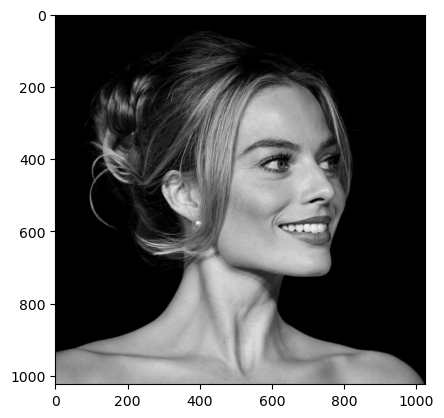

In [121]:
plt.imshow(img_tensor[0], cmap='gray')

In [122]:
img_tensor.shape

torch.Size([1, 1024, 1024])

In [123]:
def get_coords(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    grid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    grid = grid.reshape(-1, dim)
    return grid

In [124]:
class ImageFitting(data.Dataset):
    def __init__(self, sidelength, img):
        super().__init__()
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_coords(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels

In [125]:
img_dataset = ImageFitting(sidelen, img_tensor)
dataloader = data.DataLoader(img_dataset, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()    

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

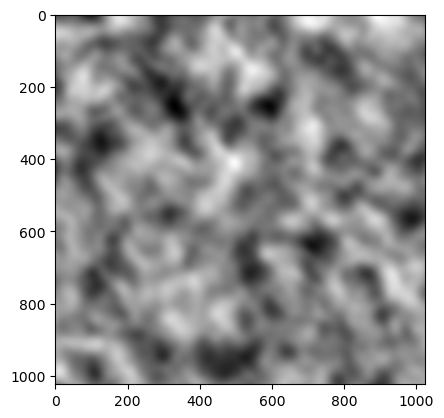

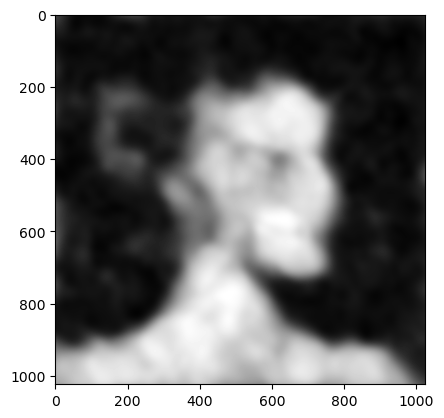

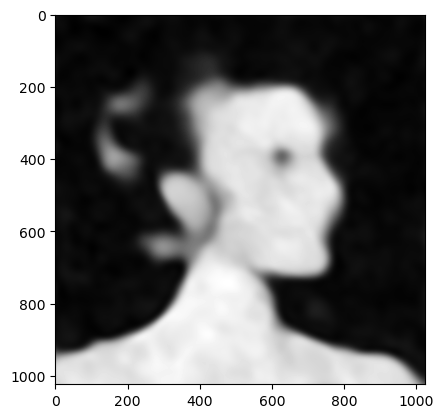

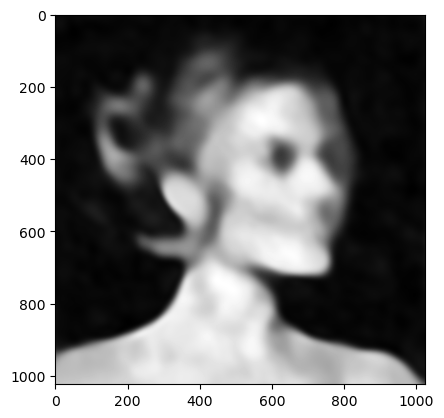

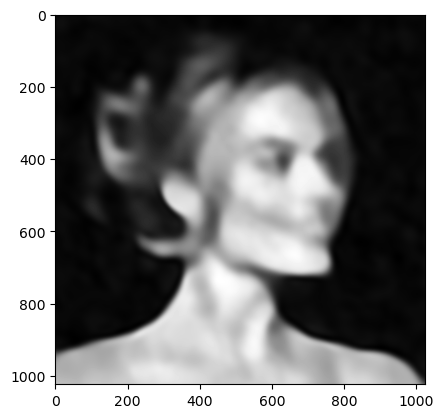

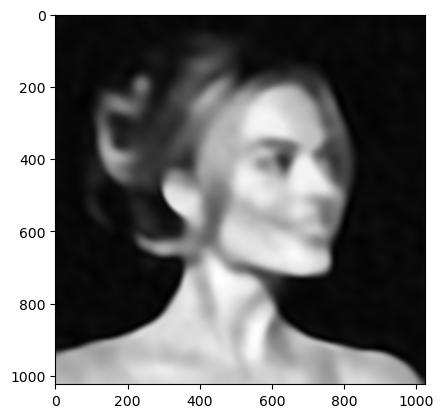

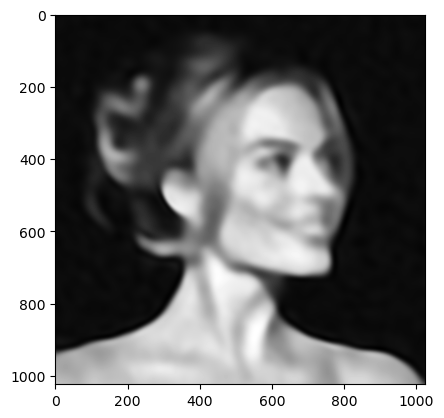

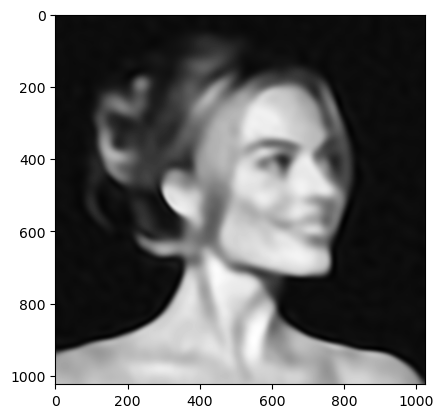

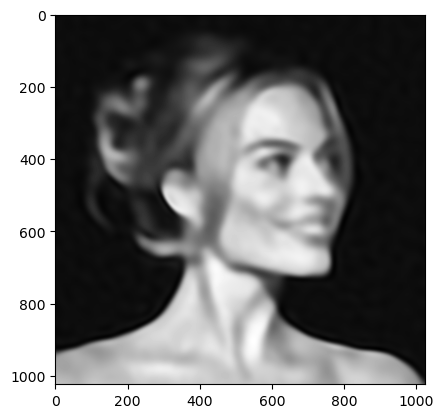

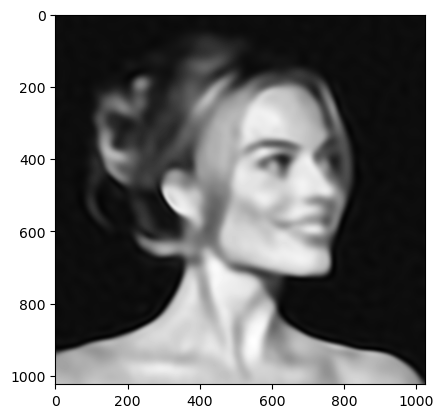

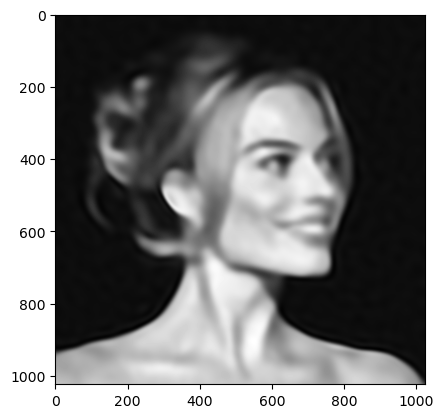

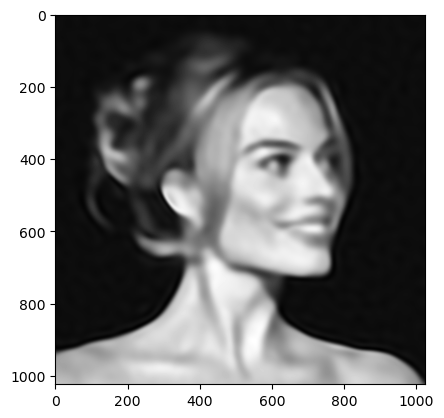

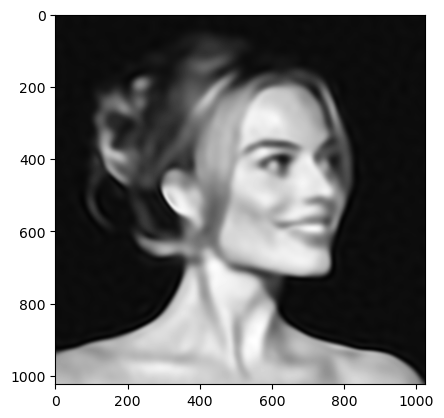

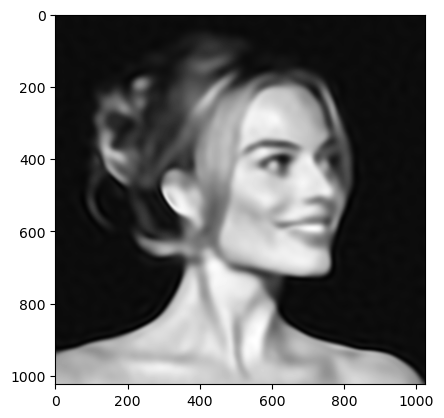

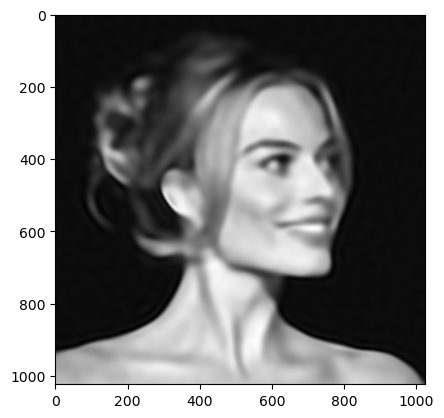

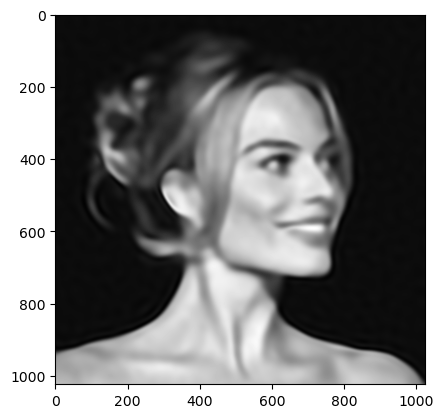

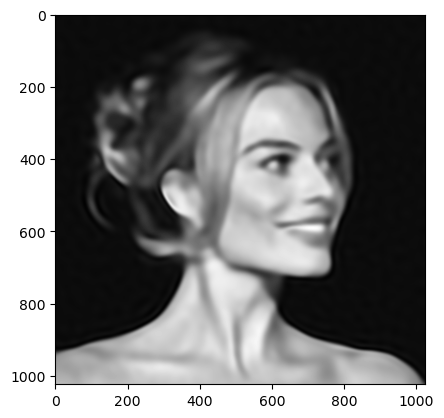

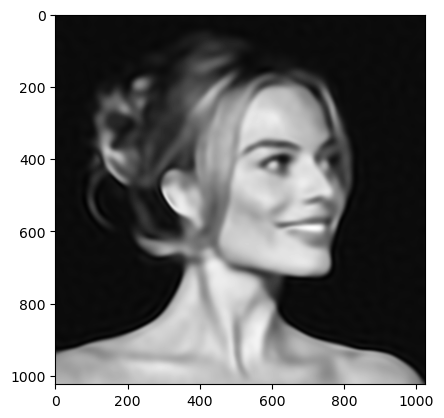

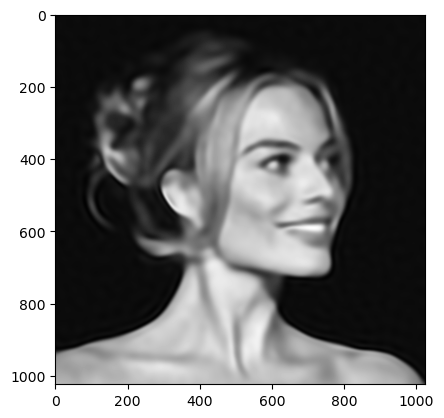

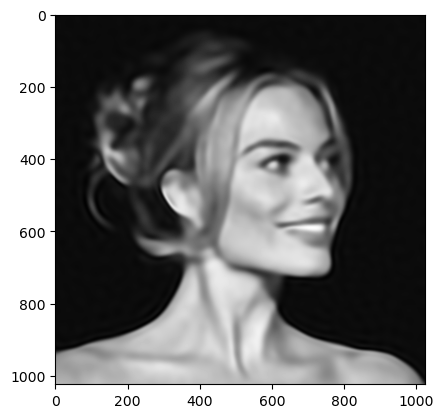

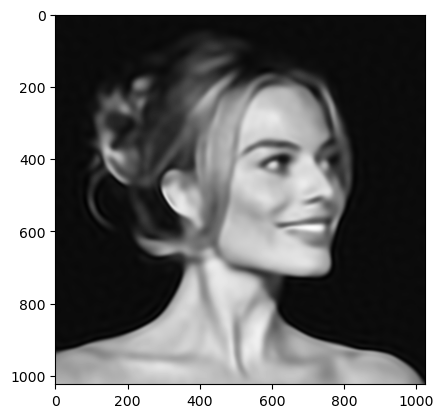

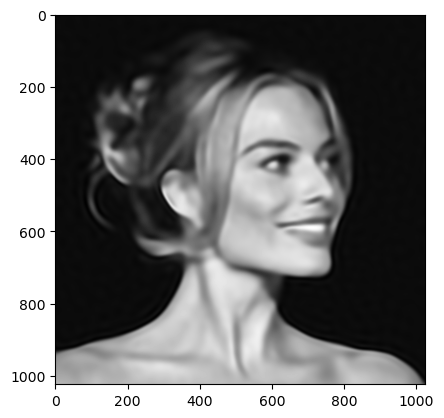

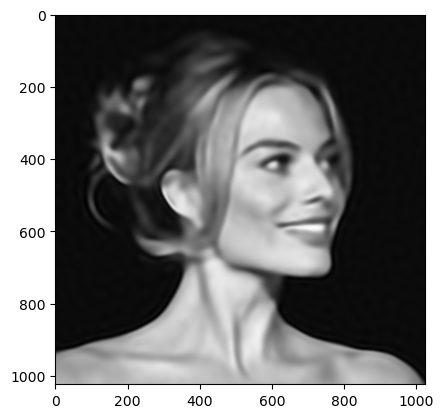

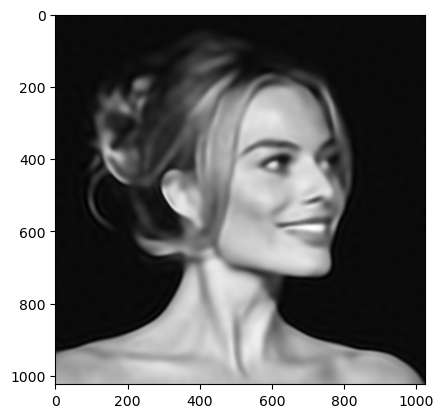

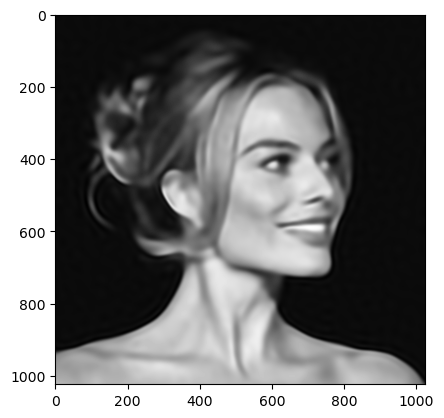

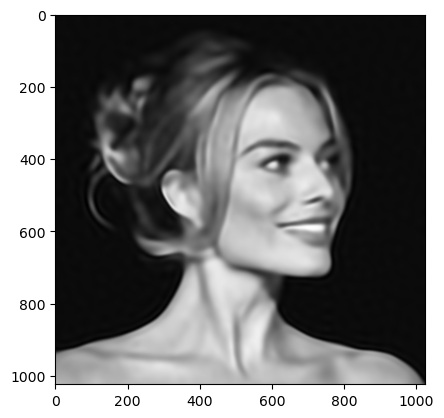

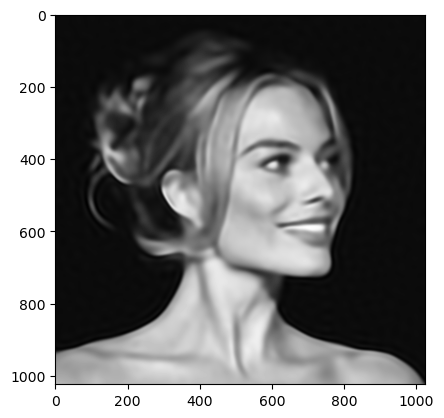

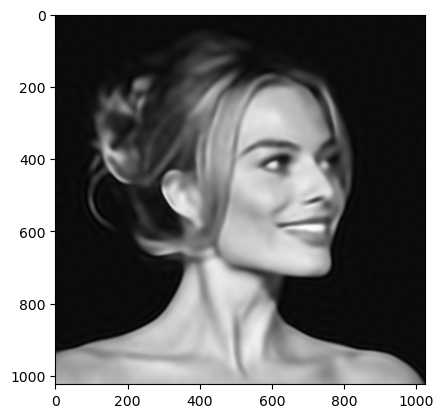

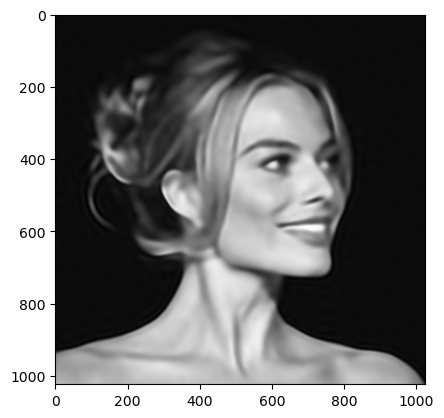

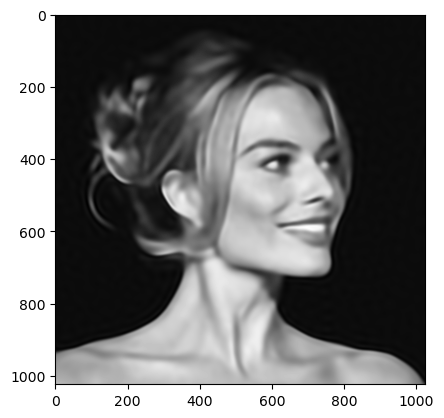

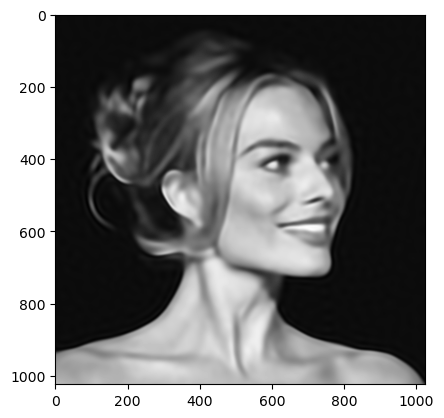

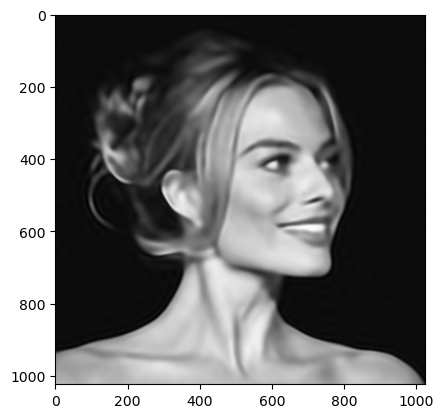

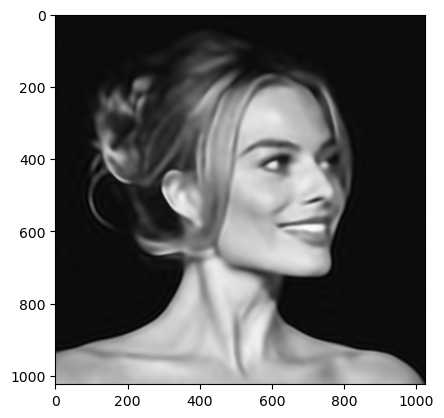

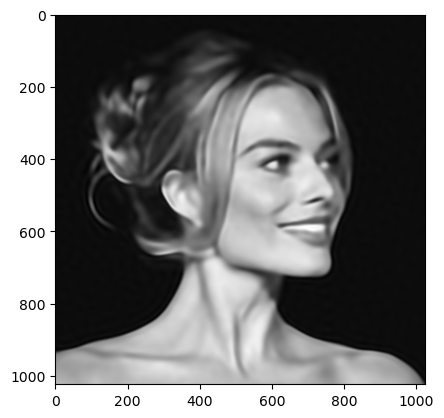

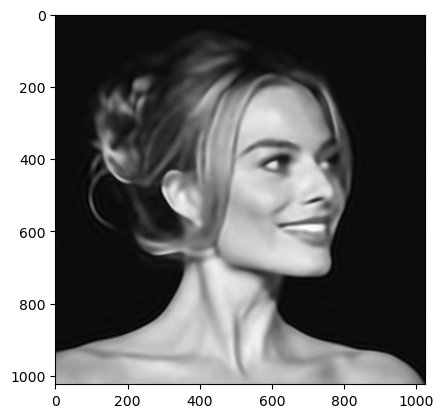

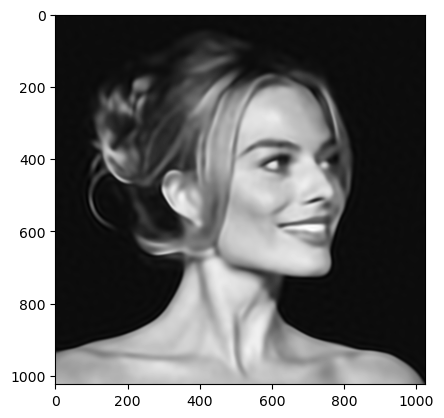

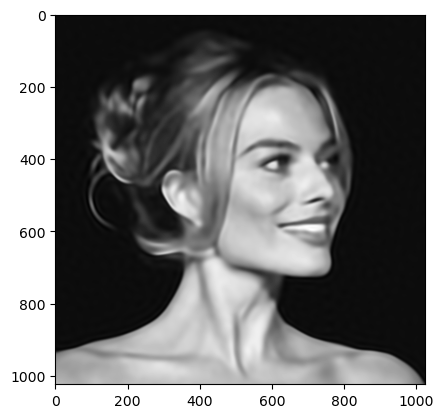

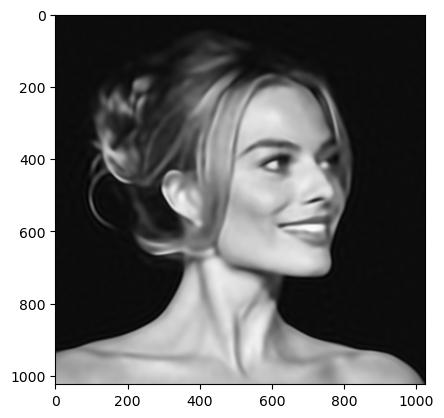

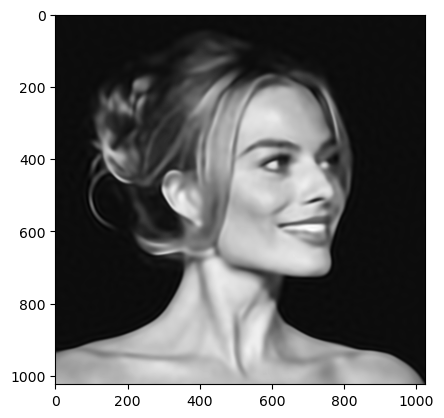

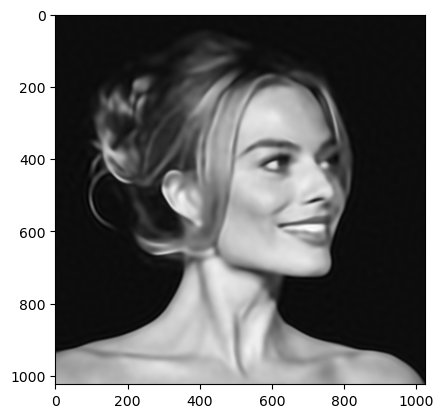

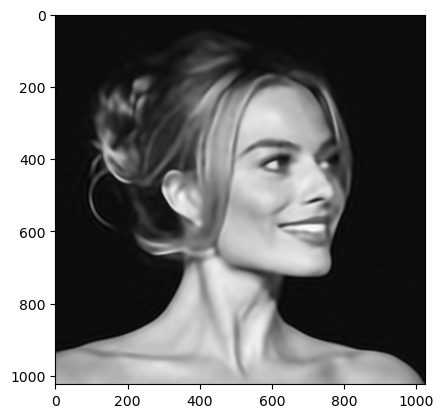

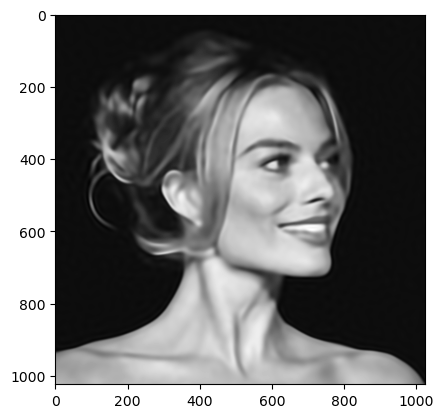

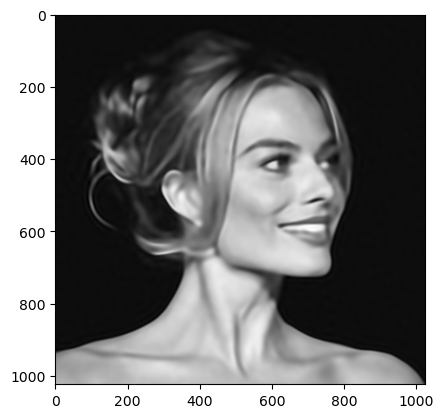

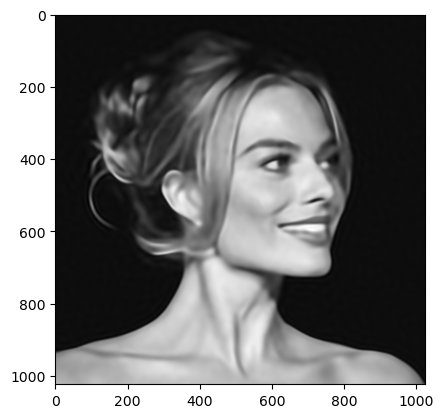

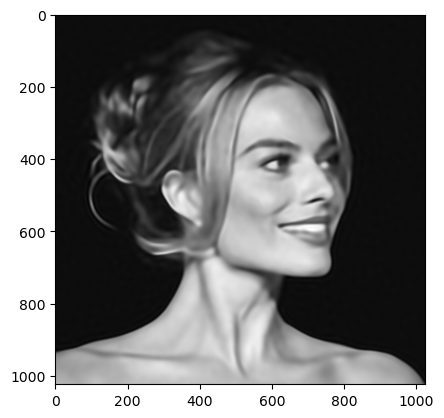

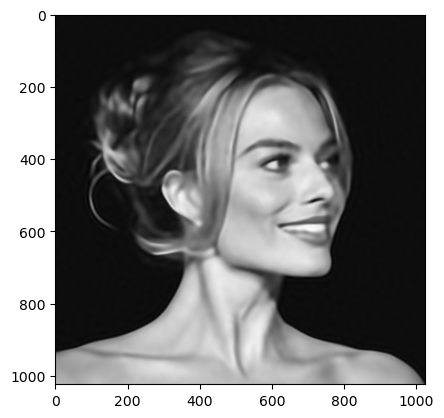

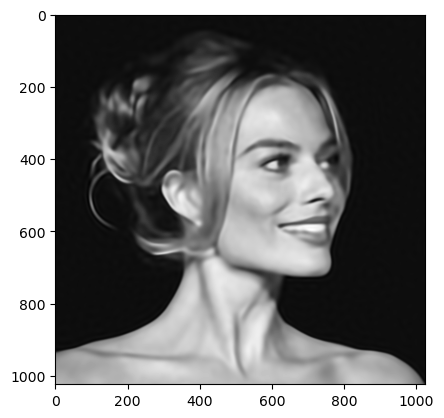

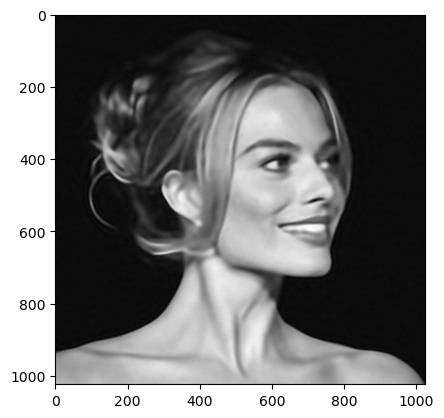

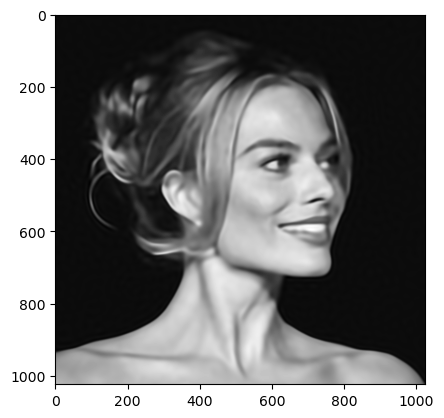

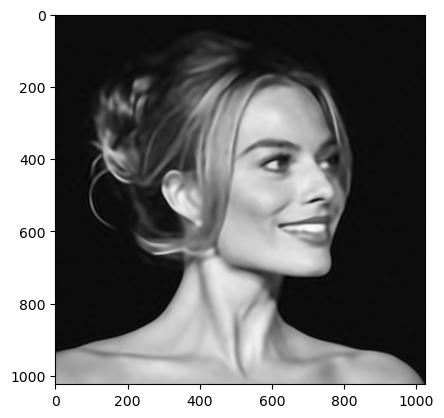

In [126]:
total_steps = 500

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output, coords = img_siren(model_input)
    loss = ((model_output - ground_truth)**2).mean()

    optim.zero_grad()
    loss.backward()
    optim.step()

    if step % 10 == 0:
        img_output = model_output.detach().cpu().numpy()
        img_output = img_output.reshape(sidelen, sidelen)
        plt.imshow(img_output, cmap='gray')
        plt.show()

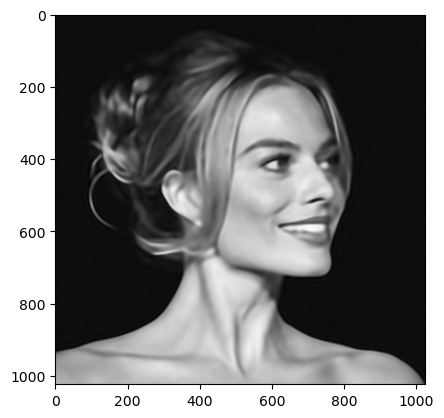

In [127]:
model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

img_output, _ = img_siren(model_input)
img_output = img_output.view(sidelen, sidelen).cpu().detach().numpy()
plt.imshow(img_output, cmap='gray')

In [131]:
scale_factor = 2

class SuperResolution(data.Dataset):
    def __init__(self, sidelength, img):
        super().__init__()
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_coords(math.ceil(sidelength * scale_factor), 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels

In [132]:
img_dataset = SuperResolution(sidelen, img_tensor)
supergrid_loader = data.DataLoader(img_dataset, batch_size=1, pin_memory=True, num_workers=0)

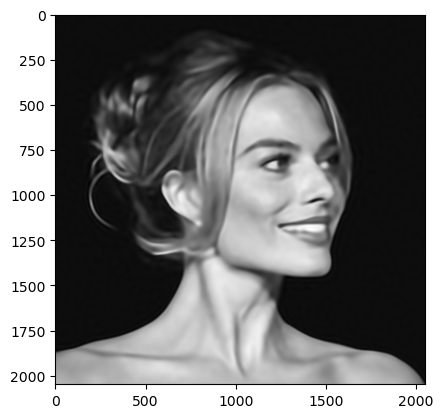

In [133]:
model_input, ground_truth = next(iter(supergrid_loader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

img_output, _ = img_siren(model_input)
img_output = img_output.view(math.ceil(sidelen * scale_factor), math.ceil(sidelen * scale_factor)).cpu().detach().numpy()
plt.imshow(img_output, cmap='gray')
plt.savefig('superres.png', dpi = 500)